In [1]:
import os
import sknw
import skimage
import skimage.filters

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

## Chargement des images

Nous chargeons le dataset sous forme de trois numpy arrays, contenant respectivement les images à traiter (en nuances de gris), les masques permettant d'ignorer les extrémités des ces dernières, et enfin les vérités terrains correspondantes.

In [2]:
# Setup directories variables
dataset_dir = "dataset/"
img_dir = dataset_dir + "images/"
manual_dir = dataset_dir + "manual1/"
mask_dir = dataset_dir + "mask/"

In [3]:
# Loads the dataset's images in grayscale
img_dataset = np.array([np.array(Image.open(img_dir + img).convert("L")) for img in sorted(os.listdir(img_dir))])

In [4]:
# Loads the masks images as booleans (either true for values to keep or false for values to discard)
mask_dataset = np.array([np.array(Image.open(mask_dir + mask).convert("L")).astype(bool) for mask in sorted(os.listdir(mask_dir))])

In [5]:
# Loads the ground truths as 0 or 1s images (0 for background and 1 for vessel)
manual_dataset = np.array([np.array(Image.open(manual_dir + manual)) / 255 for manual in sorted(os.listdir(manual_dir))])

In [6]:
# Display the dataset shape
nb_img = img_dataset.shape[0]
print(img_dataset.shape)

(45, 2336, 3504)


(2336, 3504)


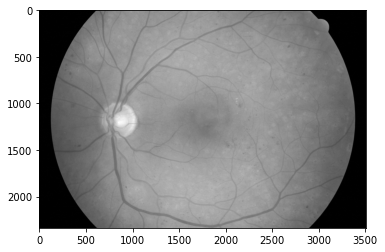

In [7]:
# Displays some test images
print(img_dataset[0].shape)

plt.imshow(img_dataset[0], cmap=plt.cm.gray)
plt.show()

(2336, 3504)


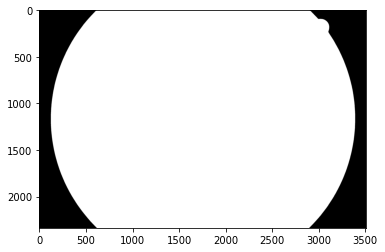

In [8]:
print(mask_dataset[0].shape)

plt.imshow(mask_dataset[0], cmap=plt.cm.gray)
plt.show()

(2336, 3504)


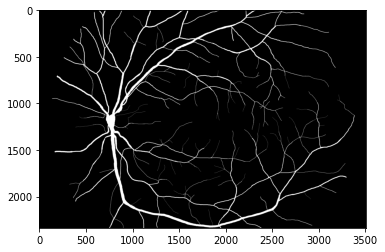

In [9]:
print(manual_dataset[0].shape)

plt.imshow(manual_dataset[0], cmap=plt.cm.gray)
plt.show()

## Segmentation de vaisseaux à l'aide d'un filtre de Frangis

En tant que filtre de vesselness, nous avons utilisé un filtre de Frangis.

Pour paramétrer le filtre utilisé, nous avons essayé plusieurs paramètres en observant les résultats visuellement et à l'aide d'un calcul de l'erreur moyenne sur les images générées. Nous avions tout d'abord choisi une échelle de valeurs de $\sigma$ assez large, pour avoir un premier filtre très large, avant de réduire progressivement l'échelle, en ne gardant que les valeurs intéressantes. Nous avons également diminué la valeurs $\beta$, car dans notre cas, les composantes en blobs de nos images correspondantes généralement à du bruit, et on ne souhaite donc pas les garder.

Une fois le filtre appliqué, nous avons utilisé les masques fournis pour éliminer de l'image les bords de l'oeil et ne garder que les vaisseaux, avant d'effectuer un seuillage pour extraire ces derniers. Pour cela, nous avions dans un premier temps choisi une valeur de seuil de façon empirique en observant et comparant les résultats obtenus pour différentes valeurs. Cependant, afin d'obtenir de meilleurs résultats, nous avons finalement utilisé des méthodes de seuillage plus efficace, et afin de les comparer simplement nous avons utilisé l'utilitaire try_all_threshold de skimage. Nous avons finalement de seuiller à l'aide de la méthode de Li.

In [11]:
# Applies the frangis filter to the dataset
frangis = np.array([skimage.filters.frangi(img, sigmas=np.arange(1, 9, 1), alpha=.5, beta=.25, gamma=15) for img in img_dataset)
print(frangis.shape)

(6, 2336, 3504)


In [12]:
# Applies the corresponding masks on the filtered images
masked_frangis = np.array([np.where(mask_dataset[i], frangis[i], 0) for i in range(nb_img)])

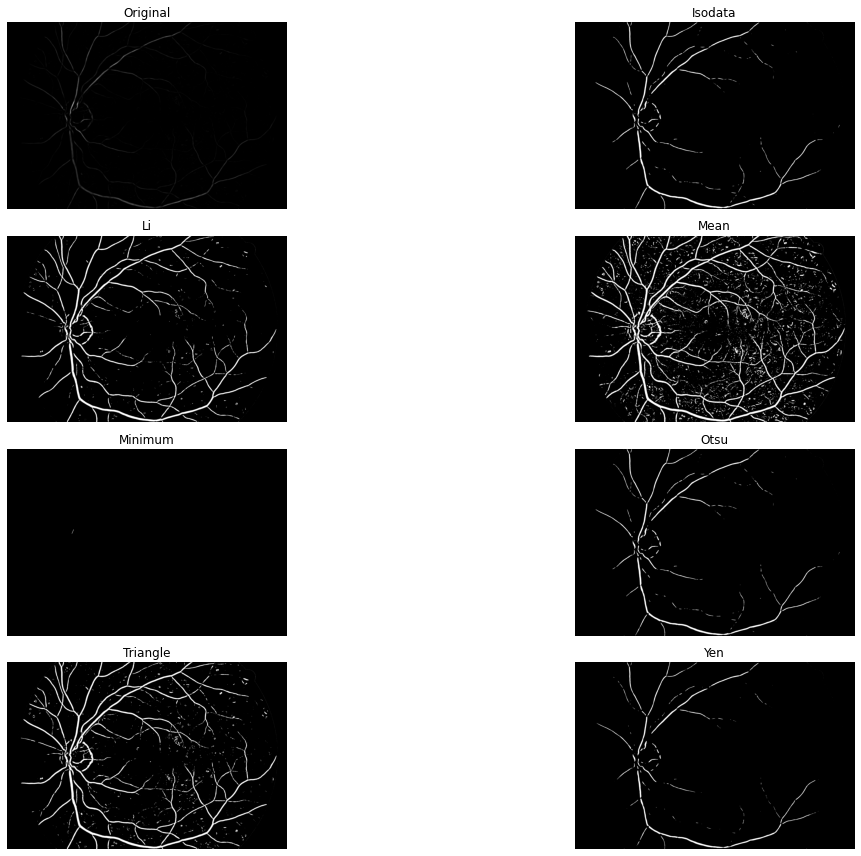

In [13]:
from skimage.filters import try_all_threshold

# Compares multiple thresholding methods to determine which is the most efficient in our case
fig, ax = try_all_threshold(masked_frangis[0], figsize=(20, 12), verbose=False)

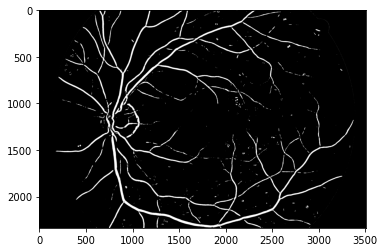

In [18]:
# Apply the Li thresholding methods to retrieve the final images
thresholded_frangis = np.array([np.where(masked_frangis[i] > skimage.filters.threshold_li(masked_frangis[i]), 1, 0) for i in range(nb_img)])

plt.imshow(thresholded_frangis[0], cmap=plt.cm.gray)
plt.show()

In [16]:
# Computes a simple error function, by the distance between each pixel of each image of the dataset,
# and compute its mean on the entire dataset to retrieve a single value
errors = np.array([np.abs(thresholded_frangis[i] - manual_dataset[i]) for i in range(nb_img)])
mean_error = np.mean(errors)

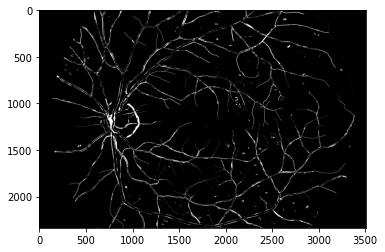

0.04107958077265904


In [17]:
# Displays the difference between the ground truth and the filtered image on the first image
plt.imshow(errors[0], cmap=plt.cm.gray)
plt.show()

print(mean_error)

## Segmentation de lignes centrales

Dans un second temps, à partir des images filtrées, nous avons dû créé un graphe des lignes centrales des vaisseaux segmentés. Pour cela, nous avons tout d'abord calculé un squelette de l'image filtré (ou de la vérité terrain) afin de n'obtenir que des traits d'un pixel de large, avant d'utilisé la bibliothèque pknw afin de générer le graph correspondant.

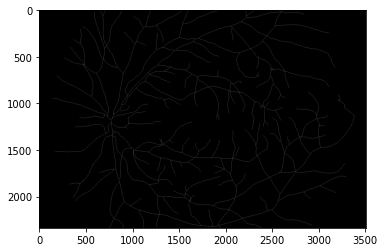

In [327]:
# Computes the skeleton of the ground truth
skels = np.array([skimage.morphology.skeletonize(img) for img in manual_dataset[:nb_img]])

plt.imshow(skels[0], cmap=plt.cm.gray)
plt.show()

In [328]:
# Finds the corresponding graph of the skeletonize image
graphs = [sknw.build_sknw(skel) for skel in skels]

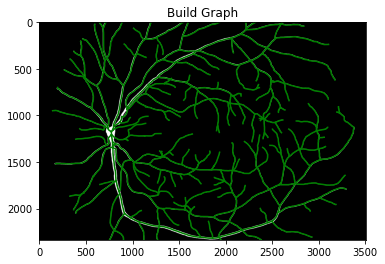

In [329]:
# Display the ground truth's graph (without the nodes, to keep the image clear)
plt.imshow(manual_dataset[0], cmap=plt.cm.gray)

for (s, e) in graphs[0].edges():
    ps = graphs[0][s][e]['pts']
    plt.plot(ps[:, 1], ps[:, 0], 'green')
plt.title('Build Graph')
plt.show()

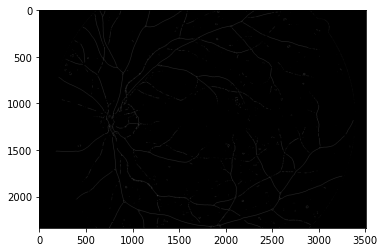

In [334]:
# Computes the skeleton of filtered images
skels_frangis = np.array([skimage.morphology.skeletonize(img) for img in thresholded_frangis[:nb_img]])

plt.imshow(skels_frangis[0], cmap=plt.cm.gray)
plt.show()

In [335]:
# Finds the graph of the skeletonize image
graphs_frangis = [sknw.build_sknw(skel) for skel in skels_frangis]

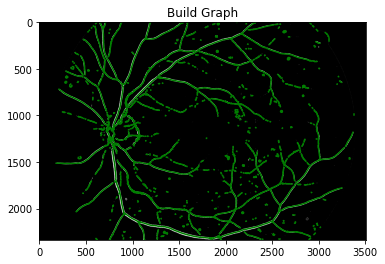

In [336]:
# Display the ground truth's graph (without the nodes, to keep the image clear)
plt.imshow(thresholded_frangis[0], cmap=plt.cm.gray)

for (s, e) in graphs_frangis[0].edges():
    ps = graphs_frangis[0][s][e]['pts']
    plt.plot(ps[:, 1], ps[:, 0], 'green')

plt.title('Build Graph')
plt.show()